In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#data = pd.read_csv("data.csv")
data = pd.read_csv("test.csv")

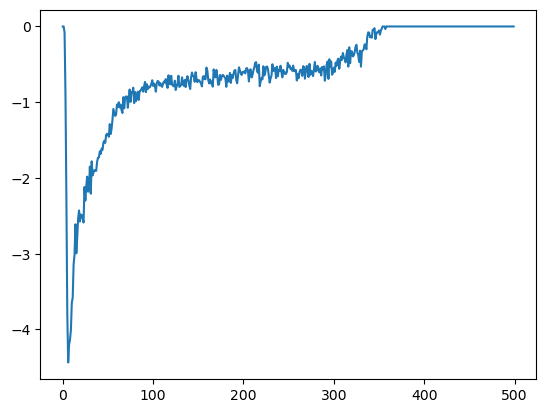

In [6]:
plt.plot(data.t, data.ICaL)
plt.show()